## 1-D CNN for Chagas ECG detection

This notebook adds a straightforward convolutional-neural-network baseline.  
It treats each ECG as a 12-channel time-series, using stacked Conv1D blocks
followed by global pooling and a dense sigmoid output.

Goals:  
- Capture local waveform patterns that tree models miss  
- Provide a TensorFlow reference architecture before experimenting with more
  complex ConvNeXt-style models  
- Keep preprocessing, splits, and metrics identical to prior notebooks for an
  apples-to-apples comparison

## Environment setup

### Import libraries

In [24]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import (
    accuracy_score, roc_auc_score, roc_curve,
    confusion_matrix, classification_report, precision_recall_curve
)
import matplotlib.pyplot as plt
from tensorflow.keras import models, layers, regularizers

### Load preprocessed datasets

In [8]:
DATA_DIR = '.'
train = np.load(f'{DATA_DIR}/train_bal_parts0-6_aug.npz')
val = np.load(f'{DATA_DIR}/val.npz')
test = np.load(f'{DATA_DIR}/test_external.npz')

# Extract arrays and labels from the loaded data
X_train, y_train = train['X'], train['y']
X_val, y_val = val['X'], val['y']
X_test, y_test = test['X'], test['y']

# Check array shapes and positive counts
print('Train :', X_train.shape,  'Positives:', y_train.sum())
print('Val   :', X_val.shape,    'Positives:', y_val.sum())
print('Test  :', X_test.shape,   'Positives:', y_test.sum())

Train : (17696, 2920, 12) Positives: 4424
Val   : (27876, 2920, 12) Positives: 553
Test  : (23430, 2920, 12) Positives: 1631


## Modeling

### Build 1-D CNN model


In [25]:
model = models.Sequential([
    layers.Conv1D(32, 5, activation='relu', input_shape=(2920, 12)),
    layers.BatchNormalization(),
    layers.MaxPooling1D(2),

    layers.Conv1D(64, 5, activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling1D(2),

    layers.Conv1D(128, 3, activation='relu'),
    layers.BatchNormalization(),
    layers.GlobalMaxPooling1D(),

    layers.Dropout(0.5),

    # Dense layer with L2 regularization
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),

    layers.Dense(1, activation='sigmoid')
])

### Train the CNN Model


In [10]:
# Convert data
X_train_tf = X_train.astype("float32")
X_val_tf = X_val.astype("float32")
X_test_tf = X_test.astype("float32")

In [26]:
# Training parameters
EPOCHS = 30
BATCH = 32

callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(patience=3, factor=0.5, verbose=1)
]

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC(name='auroc', curve='ROC'),tf.keras.metrics.AUC(name='auprc', curve='PR')])

history = model.fit(
    X_train_tf, y_train,             
    epochs=EPOCHS,
    validation_data=(X_val_tf, y_val), 
    callbacks=callbacks,
    batch_size=BATCH
)

model.summary(line_length=80)

Epoch 1/30
553/553 [==============================] - 114s 202ms/step - loss: 0.7353 - accuracy: 0.7223 - auroc: 0.6157 - auprc: 0.3539 - val_loss: 0.3685 - val_accuracy: 0.9319 - val_auroc: 0.7662 - val_auprc: 0.0917 - lr: 0.0010
Epoch 2/30
553/553 [==============================] - 105s 189ms/step - loss: 0.5274 - accuracy: 0.7694 - auroc: 0.7068 - auprc: 0.4819 - val_loss: 0.4282 - val_accuracy: 0.8772 - val_auroc: 0.7828 - val_auprc: 0.0962 - lr: 0.0010
Epoch 3/30
553/553 [==============================] - 153s 277ms/step - loss: 0.4963 - accuracy: 0.7832 - auroc: 0.7438 - auprc: 0.5266 - val_loss: 0.3282 - val_accuracy: 0.9052 - val_auroc: 0.7965 - val_auprc: 0.1118 - lr: 0.0010
Epoch 4/30
553/553 [==============================] - 170s 307ms/step - loss: 0.4742 - accuracy: 0.7915 - auroc: 0.7730 - auprc: 0.5634 - val_loss: 0.2933 - val_accuracy: 0.9199 - val_auroc: 0.8039 - val_auprc: 0.1151 - lr: 0.0010
Epoch 5/30
553/553 [==============================] - 147s 266ms/step - loss

### Evaluation

In [27]:
from sklearn.metrics import (
    accuracy_score, roc_auc_score, average_precision_score,
    precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt

def keras_report(model, name, X_split, y_split, plot_cm=True):
    """
    Compute metrics for a Keras binary-classifier (sigmoid output).
    Args:
        name (str): Name of the dataset split (e.g., 'Train', 'Validation', 'External test').
        X_split (np.ndarray): Feature matrix for the split.
        y_split (np.ndarray): True labels for the split.
        plot_cm (bool): Whether to plot the confusion matrix.
    """
    y_prob = model.predict(X_split, verbose=0).squeeze()
    y_pred = y_prob >= 0.5

    acc = accuracy_score(y_split, y_pred)
    auroc = roc_auc_score(y_split, y_prob)
    auprc = average_precision_score(y_split, y_prob)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_split, y_pred, average="binary", zero_division=0
    )
    tn, fp, fn, tp = confusion_matrix(y_split, y_pred).ravel()
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

    print(f"{name} metrics")
    print(f"  accuracy     {acc:.3f}")
    print(f"  AUROC        {auroc:.3f}")
    print(f"  AUPRC        {auprc:.3f}")
    print(f"  precision    {prec:.3f}")
    print(f"  recall       {rec:.3f}")
    print(f"  specificity  {specificity:.3f}")
    print(f"  F1           {f1:.3f}\n")

    if plot_cm:
        ConfusionMatrixDisplay(
            confusion_matrix(y_split, y_pred),
            display_labels=["Neg", "Pos"],
        ).plot(cmap="Blues")
        plt.title(f"{name} confusion matrix")
        plt.show()


Train metrics
  accuracy     0.842
  AUROC        0.885
  AUPRC        0.746
  precision    0.835
  recall       0.458
  specificity  0.970
  F1           0.591



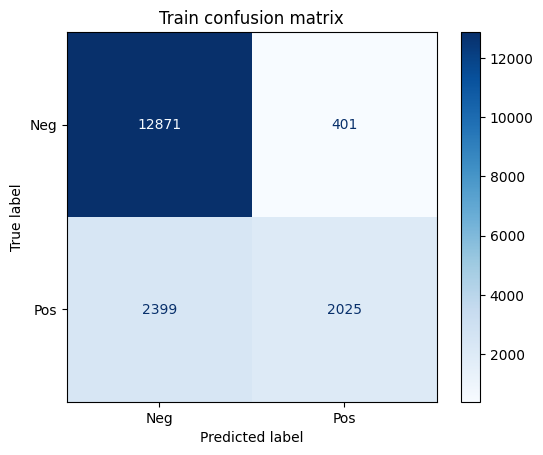

Validation metrics
  accuracy     0.946
  AUROC        0.830
  AUPRC        0.133
  precision    0.151
  recall       0.373
  specificity  0.958
  F1           0.215



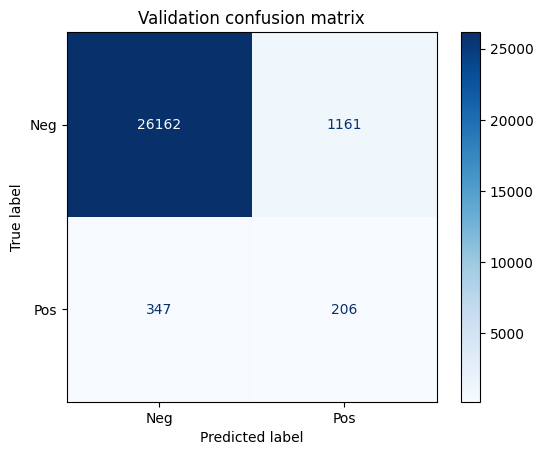

External test metrics
  accuracy     0.890
  AUROC        0.695
  AUPRC        0.223
  precision    0.253
  recall       0.300
  specificity  0.934
  F1           0.274



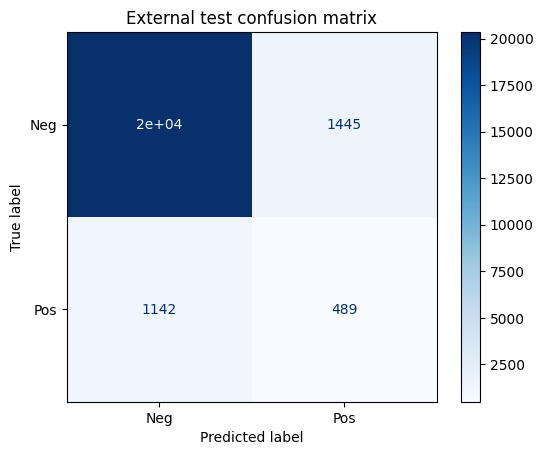

In [28]:
# Evaluate the model on different splits
keras_report(model, "Train", X_train_tf, y_train)
keras_report(model, "Validation", X_val_tf, y_val)
keras_report(model, "External test", X_test_tf, y_test)

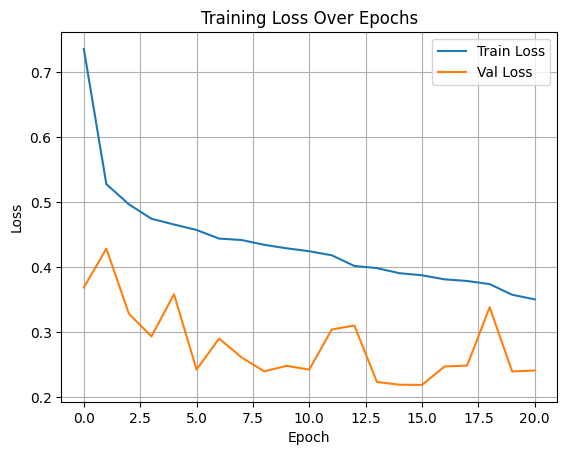


Model Parameters:
Total parameters: 46,177
Trainable parameters: 45,729


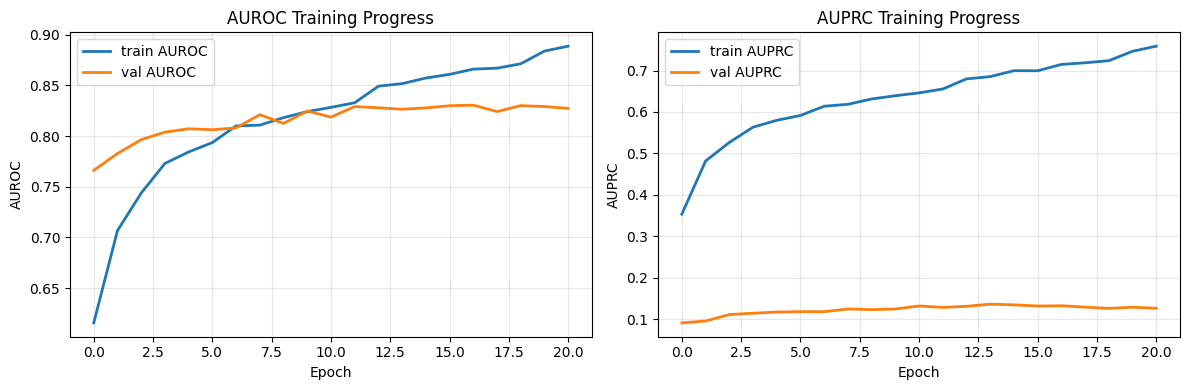


Best Performance:
Epoch: 17
Validation AUROC: 0.8306
Validation AUPRC: 0.1330


In [31]:
# Plot training loss
plt.figure()
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Model parameter count
total_params = model.count_params()
trainable_params = sum(
    [tf.keras.backend.count_params(w) for w in model.trainable_weights]
)
print(f"\nModel Parameters:")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

# Plot both AUROC and AUPRC training curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# AUROC plot
ax1.plot(history.history["auroc"], label="train AUROC", linewidth=2)
ax1.plot(history.history["val_auroc"], label="val AUROC", linewidth=2)
ax1.set_xlabel("Epoch")
ax1.set_ylabel("AUROC")
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_title("AUROC Training Progress")

# AUPRC plot
ax2.plot(history.history["auprc"], label="train AUPRC", linewidth=2)
ax2.plot(history.history["val_auprc"], label="val AUPRC", linewidth=2)
ax2.set_xlabel("Epoch")
ax2.set_ylabel("AUPRC")
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_title("AUPRC Training Progress")

plt.tight_layout()
plt.show()

# Print best epoch info
best_epoch = np.argmax(history.history["val_auroc"])
best_val_auroc = max(history.history["val_auroc"])
best_val_auprc = history.history["val_auprc"][best_epoch]

print(f"\nBest Performance:")
print(f"Epoch: {best_epoch + 1}")
print(f"Validation AUROC: {best_val_auroc:.4f}")
print(f"Validation AUPRC: {best_val_auprc:.4f}")